In [16]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
from utils_model_sampling import sample_models_across_time

In [18]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order()) # Should you run things locally?

Loading all all False 0 adult
Loading all all False 20 adult
Loading all all True 0 childes
Loading all all True 20 childes
Loading all all False 0 childes
Loading all all False 20 childes
Loading age young True 0 childes
Loading age young True 20 childes
Loading age young False 0 childes
Loading age young False 20 childes
Loading age old True 0 childes
Loading age old True 20 childes
Loading age old False 0 childes
Loading age old False 20 childes
Loading all all False 0 flat_unigram
Loading all all False 0 data_unigram


In [61]:
raw_scores_across_time['model'].shape

(213767,)

In [62]:
set(raw_scores_across_time['model'])

{'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , +-20 utts context',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

In [21]:
raw_scores_across_time['model'] # Need to select which?

# From the original analysis
original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram',
}


is_filter = True
if is_filter:
# Don't filter
    scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(original_set_of_models)]
else:
    scores_across_time = raw_scores_across_time

In [22]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [23]:
set(scores_across_time_short['model'])

{'CHILDES Unigram'}

In [24]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT with tags, , +-20 utts context",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT with tags, , same utt only",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT with tags, , +-20 utts context" = "BERT+Context+Tags",
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT with tags, , same utt only" = "BERT+OneUtt+Tags",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# 10 Average Prior Surprisal

In [25]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

          model prior_surprisal
1 CHILDES 1gram        8.655627


In [26]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id CHILDES 1gram
1        332751  7.241518e-05
2        341320  7.990609e-05
3        450431  9.301517e-05
4       1233954  2.570254e-02
5       1461059  2.189029e-02
6       1461060  3.763246e-03


In [27]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

R[write to console]: Error in rvs[model_idx, comparison_model_idx] <- NA : 
  incorrect number of subscripts on matrix




Error in rvs[model_idx, comparison_model_idx] <- NA : 
  incorrect number of subscripts on matrix


### Posterior Surprisal Across Ages

## Note to self: Check correctness of young/old divide len stdev here -- possibly ask about this; Is probably adaptive?

In [28]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

  age         model posterior_surprisal_mean posterior_surprisal_sem
1 0.5 CHILDES 1gram                 2.203031               0.9725621
2 1.5 CHILDES 1gram                 3.554576               1.3751783
3 3.5 CHILDES 1gram                 1.686699               0.5058388


,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,CHILDES 1gram,2.203031,0.972562
2,1.5,CHILDES 1gram,3.554576,1.375178
3,3.5,CHILDES 1gram,1.686699,0.505839


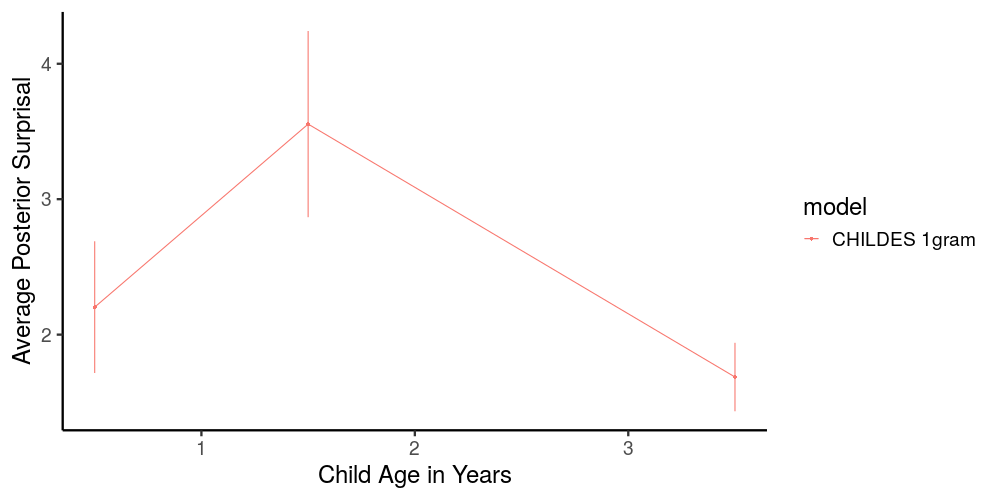

In [29]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [30]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,CHILDES 1gram,8.825021,0.289153
2,1.5,CHILDES 1gram,9.328591,0.681415
3,3.5,CHILDES 1gram,8.342686,0.331020


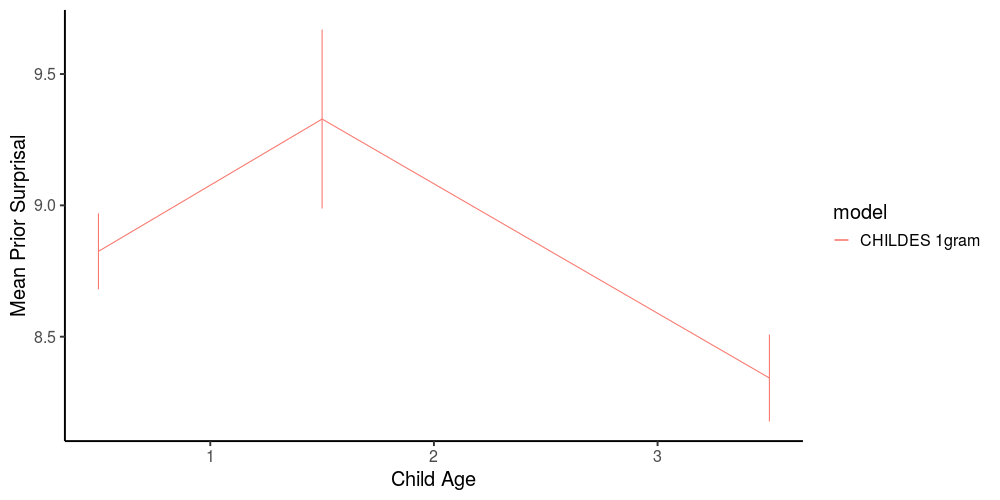

In [31]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [32]:
scores_across_time_short.set.value_counts()

success    76
failure    50
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [33]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,CHILDES 1gram,success,2.251791,0.348767
2,1.5,CHILDES 1gram,success,2.791717,0.321126
3,1.0,CHILDES 1gram,failure,3.116565,0.333001
4,2.5,CHILDES 1gram,failure,3.783325,0.354422
5,2.0,CHILDES 1gram,failure,3.643293,0.233063
6,3.5,CHILDES 1gram,success,2.511746,0.158795
7,3.0,CHILDES 1gram,failure,3.237520,0.352178
8,4.0,CHILDES 1gram,failure,3.186028,0.151728


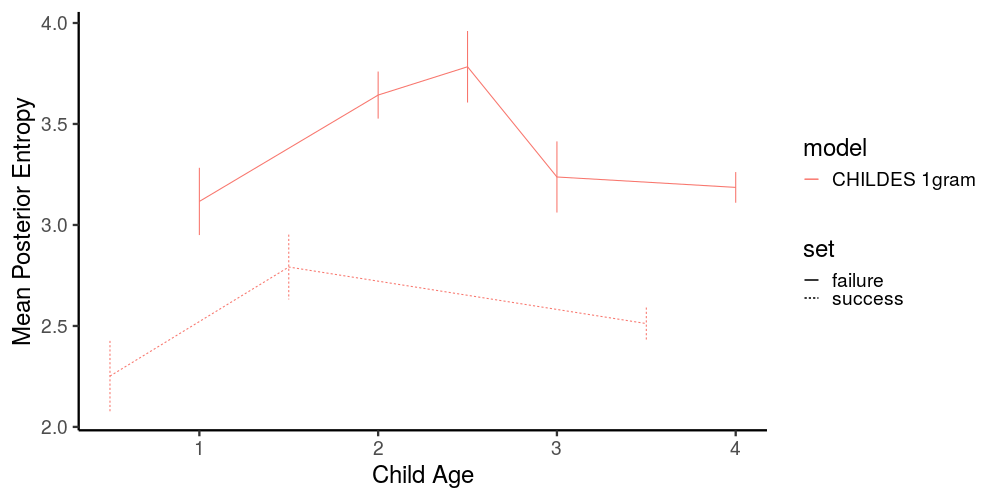

In [34]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [35]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [36]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age         model      gain  gain_sem   comparison age_in_months
1 0.5 CHILDES 1gram 13.748450 0.3744193    posterior             6
2 1.5 CHILDES 1gram 13.767674 0.6179942    posterior            18
3 3.5 CHILDES 1gram 14.846050 0.3135741    posterior            42
4 0.5 CHILDES 1gram  5.705096 0.0000000 fitted prior             6
5 1.5 CHILDES 1gram  5.705096 0.0000000 fitted prior            18
6 3.5 CHILDES 1gram  5.705096 0.0000000 fitted prior            42


In [37]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

[1] age           model         gain          gain_sem      comparison   
[6] age_in_months
<0 rows> (or 0-length row.names)


In [38]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

R[write to console]: Error in `[<-.data.frame`(`*tmp*`, "comparison", value = "perceptual data") : 
  replacement has 1 row, data has 0




Error in `[<-.data.frame`(`*tmp*`, "comparison", value = "perceptual data") : 
  replacement has 1 row, data has 0


In [39]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

R[write to console]: Error in kls_with_uniform_prior$comparison[kls_with_uniform_prior$comparison ==  : 
  object 'kls_with_uniform_prior' not found




Error in kls_with_uniform_prior$comparison[kls_with_uniform_prior$comparison ==  : 
  object 'kls_with_uniform_prior' not found


In [40]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

R[write to console]: Error in subset(kls_with_uniform_prior, age_in_months > 6) : 
  object 'kls_with_uniform_prior' not found




Error in subset(kls_with_uniform_prior, age_in_months > 6) : 
  object 'kls_with_uniform_prior' not found


# 12 Posterior Probability as a function of edit distance

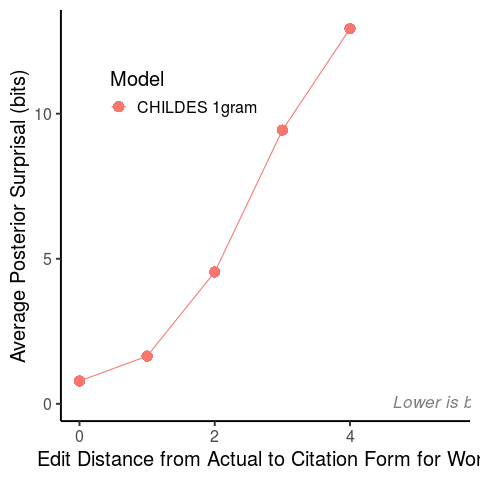

In [41]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [42]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


[1] edit_distance                model                       
[3] mean_posterior_surprisal     mean_posterior_surprisal_sem
[5] high                         low                         
[7] unigram_prior_prob           multiplier                  
<0 rows> (or 0-length row.names)


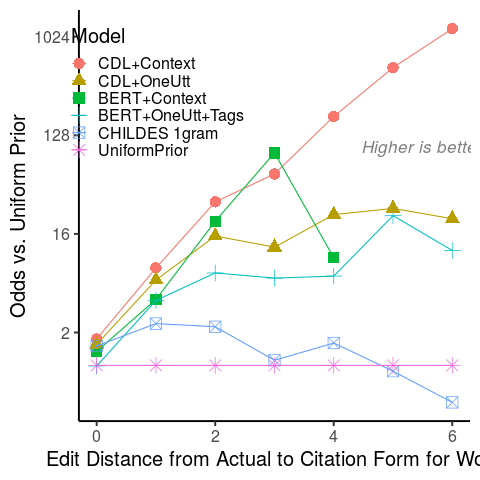

In [74]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

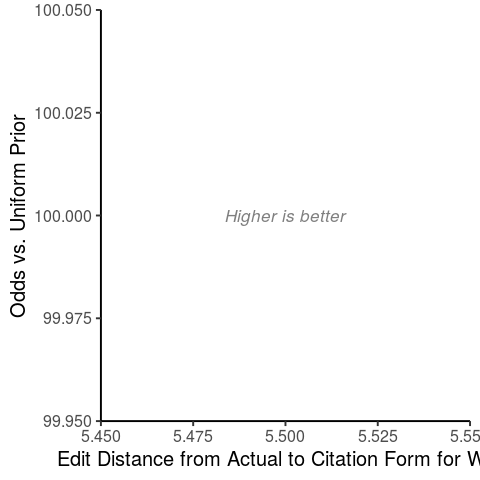

In [43]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [44]:
%%R
library(plotROC)

In [45]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 76 50


In [46]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

[1] "CHILDES 1gram"


In [47]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



In [48]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [49]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "CHILDES 1gram (AUC = 0.71)" "CHILDES 1gram (AUC = 0.71)"
 [3] "CHILDES 1gram (AUC = 0.71)" "CHILDES 1gram (AUC = 0.71)"
 [5] "CHILDES 1gram (AUC = 0.71)" "CHILDES 1gram (AUC = 0.71)"
 [7] "CHILDES 1gram (AUC = 0.71)" "CHILDES 1gram (AUC = 0.71)"
 [9] "CHILDES 1gram (AUC = 0.71)" "CHILDES 1gram (AUC = 0.71)"


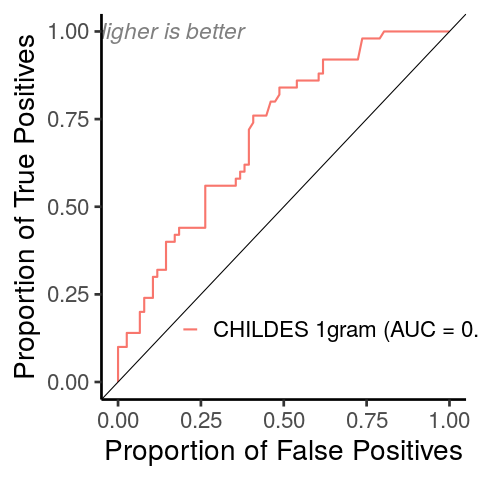

In [50]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=8, width=8)    